In [61]:
# 라이브러리 불러오기기
import pandas as pd
import matplotlib.pyplot as plt
import openai
import json
import os
from dotenv import load_dotenv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler

In [62]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [63]:
current_directory = os.getcwd()
data_directory = os.path.join(current_directory, '..', 'data')
data_file_path = os.path.join(data_directory, 'description_complete2.csv')
df = pd.read_csv(data_file_path,index_col=0)

### 전처리

In [64]:
df['foreignn'] = df['foreignn'].apply(lambda x: '국내' if x in ['Domestic', 'domestic'] else x)
df['stay_type'] = df['stay_type'].apply(lambda x: '호텔' if x in ['Hotel', '해외 호텔','hotel','해외'] else x)
df.dropna(subset=['shipping_fee'],inplace=True)
df.reset_index(drop=True, inplace=True)
df['foreignn'] = df['foreignn'].fillna("국내")
df['stay_type'] = df['stay_type'].fillna("호텔")

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1912 entries, 0 to 1911
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   platform            1912 non-null   object 
 1   original_link       1912 non-null   object 
 2   post_time           1912 non-null   object 
 3   title               1912 non-null   object 
 4   view_count          1912 non-null   int64  
 5   like_count          1912 non-null   int64  
 6   price               1912 non-null   int64  
 7   images              1912 non-null   object 
 8   description         1912 non-null   object 
 9   category            1912 non-null   object 
 10  status              1912 non-null   object 
 11  seller_location     354 non-null    object 
 12  city_goo            136 non-null    object 
 13  citydong            341 non-null    object 
 14  description_1       1912 non-null   object 
 15  expiration_stdate   685 non-null    object 
 16  expira

In [66]:
missing_ratio = df.isnull().mean() * 100

missing_ratio = missing_ratio.sort_values(ascending=False)

missing_ratio

event                 95.554393
city_goo              92.887029
check_out_time        86.297071
check_in_time         86.297071
citydong              82.165272
seller_location       81.485356
market_price          71.809623
head_count            69.926778
expiration_stdate     64.173640
expiration_endate     62.029289
options               53.661088
transaction_method    41.004184
room_type             35.774059
parking               33.263598
stay_type              0.000000
shipping_fee           0.000000
foreignn               0.000000
platform               0.000000
original_link          0.000000
description_1          0.000000
status                 0.000000
category               0.000000
description            0.000000
images                 0.000000
price                  0.000000
like_count             0.000000
view_count             0.000000
title                  0.000000
post_time              0.000000
advertise              0.000000
dtype: float64

### room_type 그룹화

In [67]:
mapping = {
    '디럭스': '디럭스',
    'deluxe': '디럭스',
    'delux': '디럭스',
    '스탠다드': '스탠다드',
    '스텐다드': '스탠다드',
    'standard': '스탠다드',
    '슈페리어': '수페리어',
    '수페리어': '수페리어',
    '수페리얼': '수페리어',
    'superior': '수페리어',
    '이그제큐티브': '이그제큐티브',
    'executive': '이그제큐티브',
    '스위트': '스위트',
    'sweet': '스위트',
    'suite': '스위트',
    '프리미엄':'프리미엄',
    '프리미어':'프리미엄',
    '패밀리': '패밀리',
    'family': '패밀리',
    '싱글': '싱글',
    'single': '싱글',
    'double': '더블&트윈',
    'twin':'더블&트윈',
    '더블': '더블&트윈',
    '트윈': '더블&트윈',
    '트리플':'트리플',
    '모텔': '모텔',
    '일반': '일반',
    '뷰': '뷰 룸',
    '오션뷰': '뷰 룸'
}

# 나머지에 대한 기본값 추가
mapping['기타'] = '기타'
mapping['정보 없음'] = '정보 없음'

# 새로운 컬럼 생성 함수
def map_room_type(room):
    if pd.isna(room):
        return '정보 없음'
    room_lower = room.lower()  # 입력된 room_type을 소문자로 변환
    for key in mapping.keys():
        if key.lower() in room_lower:  # 매핑 키를 소문자로 변환하여 비교
            return mapping[key]
    return '기타'

# 새로운 컬럼 추가
df['room_category'] = df['room_type'].apply(map_room_type)

In [68]:
df['room_category'].value_counts()

room_category
정보 없음     684
기타        347
디럭스       249
스탠다드      136
더블&트윈     122
스위트       106
수페리어       79
패밀리        66
프리미엄       36
뷰 룸        32
싱글         18
이그제큐티브     14
트리플        13
모텔          8
일반          2
Name: count, dtype: int64

In [69]:
df['parking'] = df['parking'].fillna('정보없음')

In [70]:
df['parking'].value_counts()

parking
False    1051
정보없음      636
True      225
Name: count, dtype: int64

### 특정 변수만 클러스터링(K-Prototype)

In [71]:
cluster_df = df[['price','like_count','view_count','stay_type','foreignn','event','parking','room_category']]

In [72]:
cluster_df.loc[cluster_df['event'].notnull(), 'event'] = 1
cluster_df.loc[cluster_df['event'].isnull(), 'event'] = 0

In [73]:
cluster_df['parking'] = cluster_df['parking'].astype('str')
# 매핑 딕셔너리 생성
parking_mapping = {
    '정보없음': 2,
    'False': 0,
    'True': 1
}

# parking 컬럼 변환
cluster_df['parking'] = cluster_df['parking'].map(parking_mapping)

C:\Users\gmldu\AppData\Local\Temp\ipykernel_22092\691217226.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['parking'] = cluster_df['parking'].astype('str')
C:\Users\gmldu\AppData\Local\Temp\ipykernel_22092\691217226.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['parking'] = cluster_df['parking'].map(parking_mapping)


In [74]:
cluster_df['parking'].value_counts()

parking
0    1051
2     636
1     225
Name: count, dtype: int64

C:\Users\gmldu\AppData\Local\Temp\ipykernel_1072\3583754921.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df[col] = le.fit_transform(cluster_df[col])
C:\Users\gmldu\AppData\Local\Temp\ipykernel_1072\3583754921.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df[col] = le.fit_transform(cluster_df[col])
C:\Users\gmldu\AppData\Local\Temp\ipykernel_1072\3583754921.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

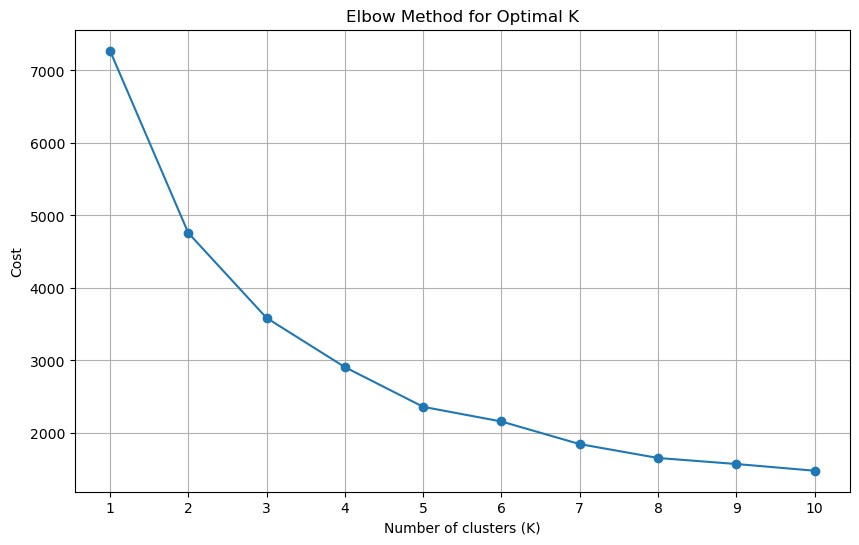

In [250]:
# 데이터 전처리
categorical_columns = ['stay_type', 'foreignn', 'event', 'parking', 'room_category']
for col in categorical_columns:
    le = LabelEncoder()
    cluster_df[col] = le.fit_transform(cluster_df[col])

numeric_columns = ['price','like_count','view_count']
scaler = StandardScaler()
cluster_df[numeric_columns] = scaler.fit_transform(cluster_df[numeric_columns])

categorical_indices = [cluster_df.columns.get_loc(col) for col in categorical_columns]

# 엘보우 기법을 위한 비용 저장 리스트
costs = []

# K 값의 범위 설정
K_range = range(1, 11)

# K-Prototypes 모델 학습 및 비용 계산
for k in K_range:
    kproto = KPrototypes(n_clusters=k, init='Huang', random_state=1004)
    clusters = kproto.fit_predict(cluster_df, categorical=categorical_indices)
    costs.append(kproto.cost_)

# 비용 시각화
plt.figure(figsize=(10, 6))
plt.plot(K_range, costs, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Cost')
plt.xticks(K_range)
plt.grid()
plt.show()

In [251]:
kproto = KPrototypes(n_clusters=3, init='Huang', random_state=1004)
clusters = kproto.fit_predict(cluster_df, categorical=categorical_indices)

cluster_df['cluster'] = clusters

C:\Users\gmldu\AppData\Local\Temp\ipykernel_1072\2321285276.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['cluster'] = clusters


In [253]:
cluster_df['cluster'].value_counts()

cluster
2    1396
0     506
1      10
Name: count, dtype: int64

<Figure size 1200x600 with 0 Axes>

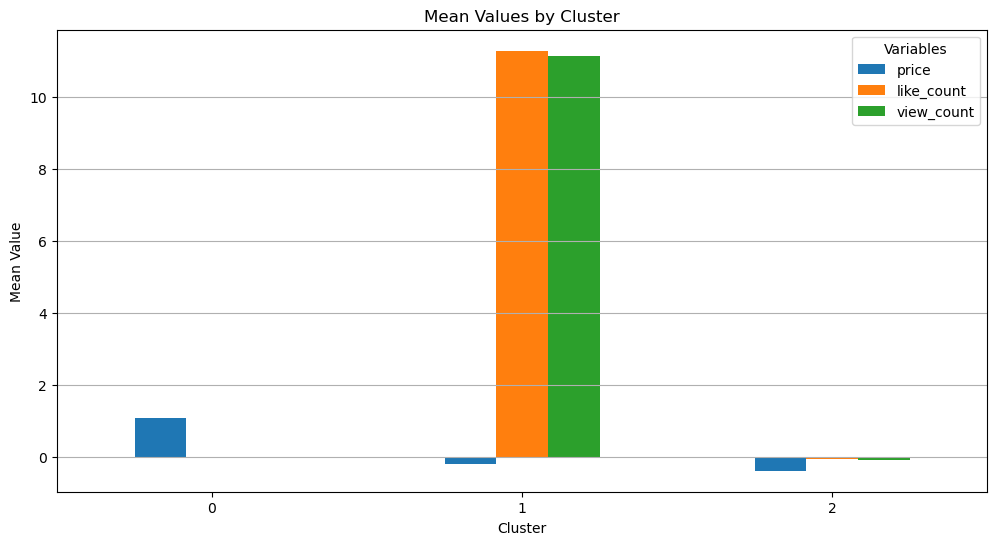

In [254]:
cluster_means = cluster_df.groupby('cluster')[numeric_columns].mean().reset_index()

plt.figure(figsize=(12, 6))
cluster_means.set_index('cluster').plot(kind='bar', figsize=(12, 6))
plt.title('Mean Values by Cluster')
plt.ylabel('Mean Value')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.legend(title='Variables')
plt.grid(axis='y')
plt.show()

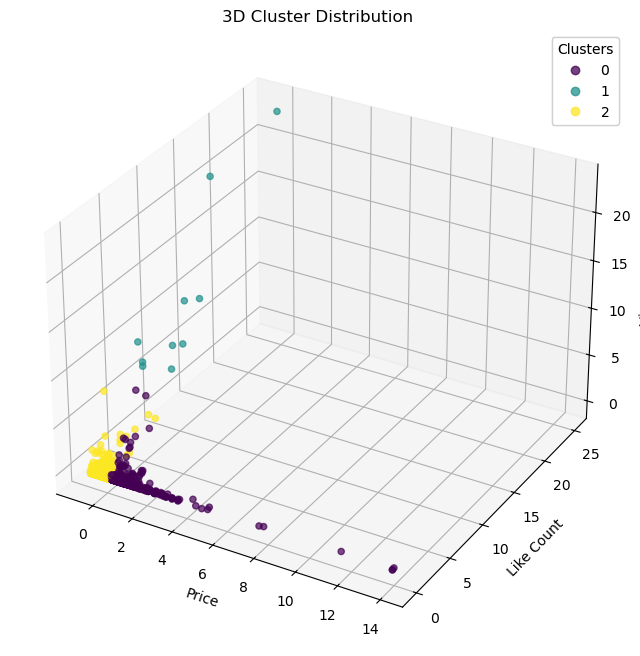

In [255]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(cluster_df['price'], cluster_df['like_count'], cluster_df['view_count'], 
                     c=cluster_df['cluster'], cmap='viridis', alpha=0.7)

ax.set_title('3D Cluster Distribution')
ax.set_xlabel('Price')
ax.set_ylabel('Like Count')
ax.set_zlabel('View Count')

legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.show()


In [256]:
df['cluster1'] = cluster_df['cluster']

In [257]:
df.groupby('cluster1')[['price','like_count','view_count']].mean()

,price,like_count,view_count
cluster1,,,
0,635474.377470,0.640316,46.778656
1,206111.100000,52.400000,2389.300000
2,138990.906877,0.459169,31.638252


In [272]:
counts = df.groupby('cluster1')['stay_type'].value_counts()
counts_df = counts.unstack(fill_value=0)
percentage_df = counts_df.div(counts_df.sum(axis=1), axis=0)
percentage_df

stay_type,기타,리조트,모텔,펜션,풀빌라,호텔
cluster1,,,,,,
0,0.043478,0.077075,0.001976,0.001976,0.007905,0.867589
1,0.000000,0.100000,0.000000,0.000000,0.000000,0.900000
2,0.069484,0.106734,0.005731,0.002865,0.003582,0.811605


<Figure size 1000x600 with 0 Axes>

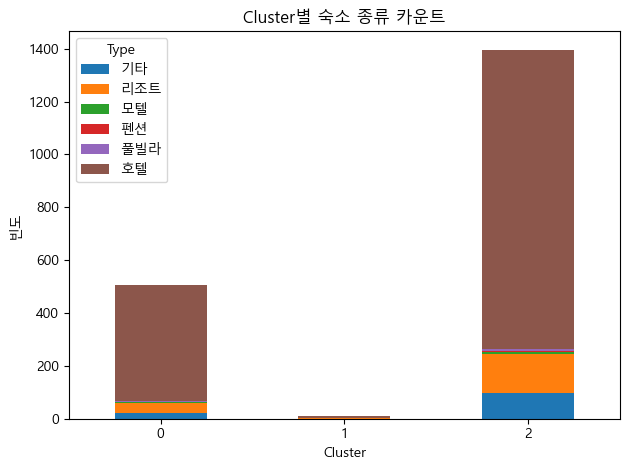

In [284]:
# 카운트 데이터 생성
counts = df.groupby(['cluster1', 'stay_type']).size().unstack(fill_value=0)
# 시각화 설정
plt.figure(figsize=(10, 6))
counts.plot(kind='bar', stacked=True)

# 제목 및 레이블 설정
plt.title('Cluster별 숙소 종류 카운트')
plt.xlabel('Cluster')
plt.ylabel('빈도')
plt.xticks(rotation=0)

# 범례 설정
plt.legend(title='Type')

# 그래프 보여주기
plt.tight_layout()
plt.show()

In [270]:
counts = cluster_df.groupby('cluster')['foreignn'].value_counts()
counts_df = counts.unstack(fill_value=0)
percentage_df = counts_df.div(counts_df.sum(axis=1), axis=0)
percentage_df.columns = ['국내','외국']
percentage_df

,국내,외국
cluster,,
0,0.901186,0.098814
1,1.000000,0.000000
2,0.904728,0.095272


<Figure size 1000x600 with 0 Axes>

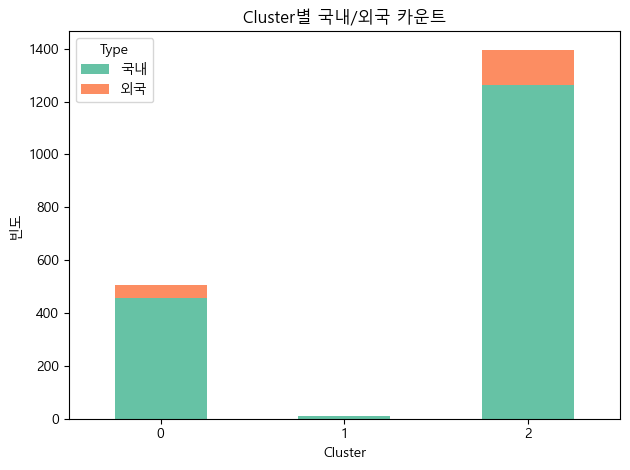

In [285]:
# 카운트 데이터 생성
counts = cluster_df.groupby(['cluster', 'foreignn']).size().unstack(fill_value=0)
counts.columns = ['국내','외국']
# 시각화 설정
plt.figure(figsize=(10, 6))
counts.plot(kind='bar', stacked=True, color=['#66c2a5', '#fc8d62'])

# 제목 및 레이블 설정
plt.title('Cluster별 국내/외국 카운트')
plt.xlabel('Cluster')
plt.ylabel('빈도')
plt.xticks(rotation=0)

# 범례 설정
plt.legend(title='Type')

# 그래프 보여주기
plt.tight_layout()
plt.show()

In [275]:
counts = cluster_df.groupby('cluster')['event'].value_counts()
counts_df = counts.unstack(fill_value=0)
percentage_df = counts_df.div(counts_df.sum(axis=1), axis=0)
percentage_df.columns = ['이벤트X','이벤트O']
percentage_df

,이벤트X,이벤트O
cluster,,
0,0.940711,0.059289
1,1.000000,0.000000
2,0.960602,0.039398


<Figure size 1000x600 with 0 Axes>

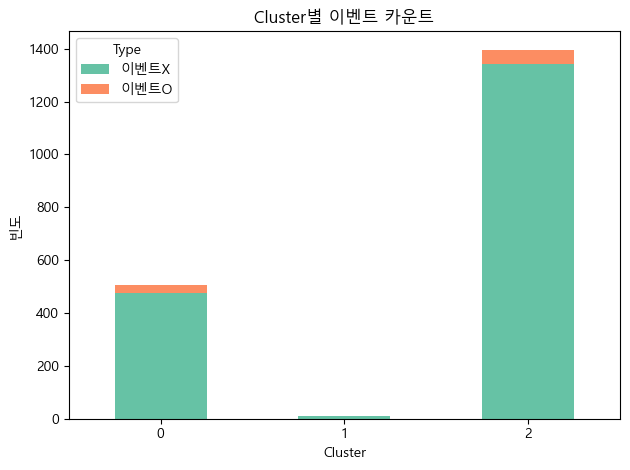

In [281]:
# 카운트 데이터 생성
counts = cluster_df.groupby(['cluster', 'event']).size().unstack(fill_value=0)
counts.columns = ['이벤트X','이벤트O']
# 시각화 설정
plt.figure(figsize=(10, 6))
counts.plot(kind='bar', stacked=True, color=['#66c2a5', '#fc8d62'])

# 제목 및 레이블 설정
plt.title('Cluster별 이벤트 카운트')
plt.xlabel('Cluster')
plt.ylabel('빈도')
plt.xticks(rotation=0)

# 범례 설정
plt.legend(title='Type')

# 그래프 보여주기
plt.tight_layout()
plt.show()

In [263]:
counts = cluster_df.groupby('cluster')['parking'].value_counts()
counts_df = counts.unstack(fill_value=0)
percentage_df = counts_df.div(counts_df.sum(axis=1), axis=0)
percentage_df.columns = ['False','True','정보없음']
percentage_df

,False,True,정보없음
cluster,,,
0,0.533597,0.136364,0.330040
1,0.600000,0.300000,0.100000
2,0.555158,0.109599,0.335244


<Figure size 1000x600 with 0 Axes>

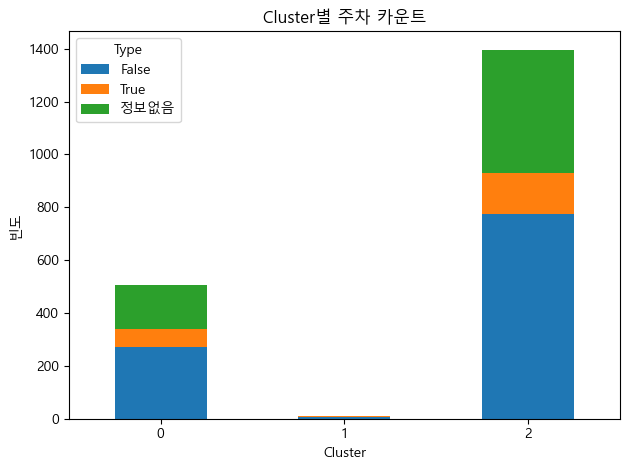

In [287]:
# 카운트 데이터 생성
counts = df.groupby(['cluster1', 'parking']).size().unstack(fill_value=0)

# 시각화 설정
plt.figure(figsize=(10, 6))
counts.plot(kind='bar', stacked=True)

# 제목 및 레이블 설정
plt.title('Cluster별 주차 카운트')
plt.xlabel('Cluster')
plt.ylabel('빈도')
plt.xticks(rotation=0)

# 범례 설정
plt.legend(title='Type')

# 그래프 보여주기
plt.tight_layout()
plt.show()

In [265]:
counts = df.groupby('cluster1')['room_category'].value_counts()
counts_df = counts.unstack(fill_value=0)
percentage_df = counts_df.div(counts_df.sum(axis=1), axis=0)
percentage_df

room_category,기타,더블&트윈,디럭스,모텔,수페리어,스위트,스탠다드,싱글,이그제큐티브,일반,정보 없음,트리플,패밀리,프리미어,프리미엄
cluster1,,,,,,,,,,,,,,,
0,0.201581,0.065217,0.179842,0.001976,0.047431,0.079051,0.039526,0.007905,0.013834,0.000000,0.274704,0.009881,0.057312,0.013834,0.007905
1,0.200000,0.000000,0.200000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,0.000000,0.100000,0.000000,0.100000
2,0.196991,0.063754,0.111748,0.005014,0.038682,0.047278,0.083095,0.010029,0.005014,0.001433,0.388252,0.005731,0.025788,0.007163,0.010029


In [101]:
# def create_room_type_columns(room_df):
#     room_df['싱글'] = room_df['room_type'].apply(lambda x: '싱글' if pd.notnull(x) and '싱글' in x.lower() else '')
#     room_df['더블'] = room_df['room_type'].apply(lambda x: '더블' if pd.notnull(x) and '더블' in x.lower() else '')
#     room_df['트윈'] = room_df['room_type'].apply(lambda x: '트윈' if pd.notnull(x) and '트윈' in x.lower() else '')
#     room_df['패밀리'] = room_df['room_type'].apply(lambda x: '패밀리' if pd.notnull(x) and ('패밀리' in x.lower() or 'family' in x.lower()) else '')
#     room_df['디럭스'] = room_df['room_type'].apply(lambda x: '디럭스' if pd.notnull(x) and ('디럭스' in x.lower() or 'deluxe' in x.lower() or 'delux' in x.lower()) else '')
#     room_df['스탠다드'] = room_df['room_type'].apply(lambda x: '스탠다드' if pd.notnull(x) and ('스탠다드' in x.lower() or '스텐다드' in x.lower() or 'standard' in x.lower()) else '')
#     room_df['수페리어'] = room_df['room_type'].apply(lambda x: '수페리어' if pd.notnull(x) and ('슈페리어' in x.lower() or '수페리어' in x.lower() or 'superior' in x.lower()) else '')
#     room_df['이그제큐티브'] = room_df['room_type'].apply(lambda x: '이그제큐티브' if pd.notnull(x) and ('이그제큐티브' in x.lower() or 'executive' in x.lower()) else '')
#     room_df['스위트'] = room_df['room_type'].apply(lambda x: '스위트' if pd.notnull(x) and ('스위트' in x.lower() or 'sweet' in x.lower() or 'suite' in x.lower()) else '')
#     room_df['모텔'] = room_df['room_type'].apply(lambda x: '모텔' if pd.notnull(x) and '모텔' in x.lower() else '')
    
#     return room_df

# # 함수 호출
# room_df = create_room_type_columns(room_df)

In [288]:
cluster_df

,price,like_count,view_count,stay_type,foreignn,event,parking,room_category,cluster
0,-0.669622,-0.170222,-0.195144,5,0,0,2,10,2
1,-0.716876,0.266936,-0.090371,5,0,0,0,6,2
2,-0.504235,-0.170222,-0.128470,5,0,0,0,0,2
3,0.263635,1.141253,0.185848,5,0,1,2,10,2
4,-0.504235,7.042887,1.457411,1,0,0,1,2,2
...,...,...,...,...,...,...,...,...,...
1907,1.563106,-0.170222,-0.080846,5,0,0,0,11,0
1908,-0.356568,-0.170222,-0.199906,5,0,0,2,10,2
1909,-0.533768,-0.170222,-0.085609,5,0,0,2,10,2
1910,-0.208900,-0.170222,0.071551,5,0,0,1,7,2


c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\clust

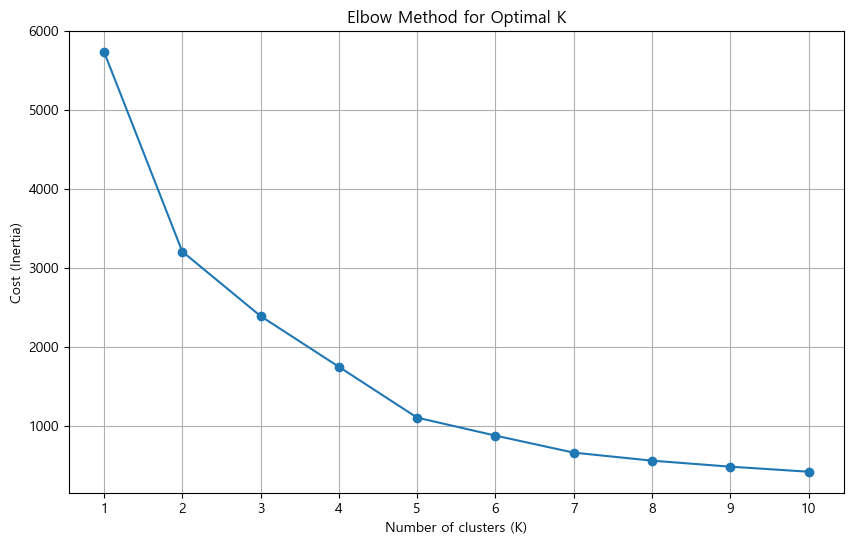

In [290]:
cluster_numdf = cluster_df[['price', 'view_count', 'like_count']]

costs = []

K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=1004)
    kmeans.fit(cluster_numdf)
    costs.append(kmeans.inertia_) 

plt.figure(figsize=(10, 6))
plt.plot(K_range, costs, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Cost (Inertia)')
plt.xticks(K_range)
plt.grid()
plt.show()


In [296]:
kmeans = KMeans(n_clusters=4, random_state=1004)
clusters = kmeans.fit_predict(cluster_numdf)
cluster_df['cluster2'] = clusters

c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\gmldu\AppData\Local\Temp\ipykernel_1072\3872742619.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_df['cluster2'] = clusters


In [297]:
cluster_df['cluster2'].value_counts()

cluster2
3    1377
0     519
1      10
2       6
Name: count, dtype: int64

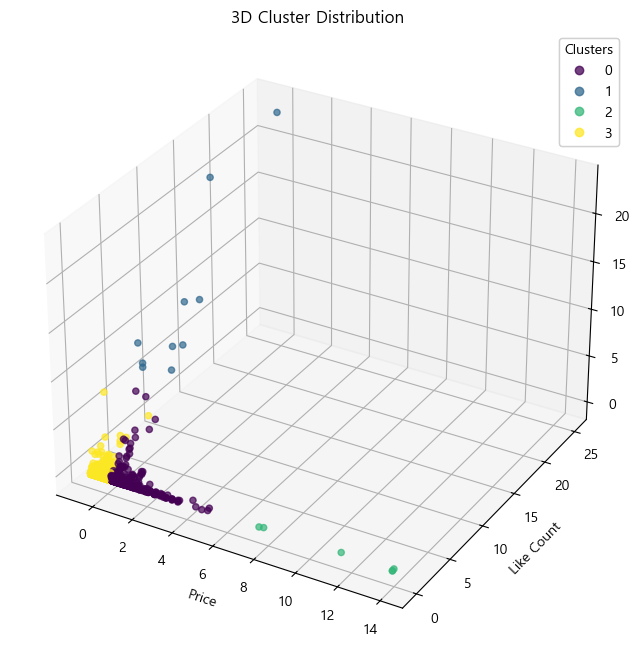

In [298]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(cluster_df['price'], cluster_df['like_count'], cluster_df['view_count'], 
                     c=cluster_df['cluster2'], cmap='viridis', alpha=0.7)

ax.set_title('3D Cluster Distribution')
ax.set_xlabel('Price')
ax.set_ylabel('Like Count')
ax.set_zlabel('View Count')

legend = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend)

plt.show()


<Figure size 1200x600 with 0 Axes>

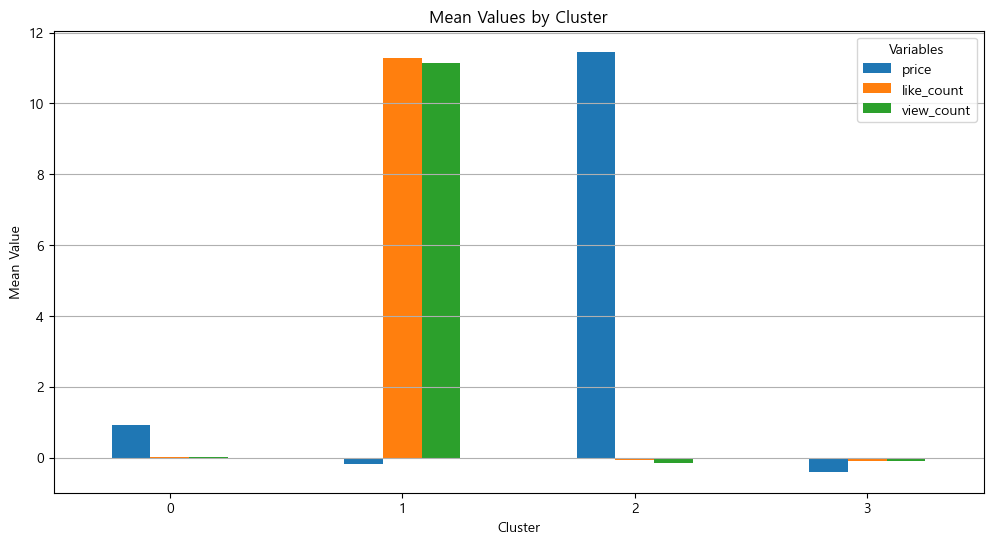

In [300]:
cluster_means = cluster_df.groupby('cluster2')[numeric_columns].mean().reset_index()

plt.figure(figsize=(12, 6))
cluster_means.set_index('cluster2').plot(kind='bar', figsize=(12, 6))
plt.title('Mean Values by Cluster')
plt.ylabel('Mean Value')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.legend(title='Variables')
plt.grid(axis='y')
plt.show()

In [301]:
df['cluster2'] = cluster_df['cluster2']

In [302]:
df.groupby('cluster2')[['price','like_count','view_count']].mean()

,price,like_count,view_count
cluster2,,,
0,5.844214e+05,0.830443,50.853565
1,2.061111e+05,52.400000,2389.300000
2,4.151667e+06,0.500000,14.500000
3,1.360615e+05,0.385621,30.034132


In [303]:
from transformers import BertModel, BertTokenizer
import torch
from sklearn.cluster import KMeans
from konlpy.tag import Okt 

model = BertModel.from_pretrained('monologg/kobert')
tokenizer = BertTokenizer.from_pretrained('monologg/kobert')

def extract_nouns(text):
    okt = Okt()
    nouns = okt.nouns(text)
    return ' '.join(nouns)

def embed_text(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# 데이터 전처리
df['description'] = df['description'].fillna('')
df['description_nouns'] = df['description'].apply(extract_nouns)
embeddings = np.array([embed_text(desc) for desc in df['description_nouns']])


config.json:   0%|          | 0.00/426 [00:00<?, ?B/s]

c:\Users\gmldu\anaconda3\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\gmldu\.cache\huggingface\hub\models--monologg--kobert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/369M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/263 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


In [311]:
df['description_nouns']

0                                                  못 가게 니
1       농심 호텔 허심 청 브로 옥토버페스트 수제 맥주 축제 목 토 기간 날짜 티켓 사용 ...
2                      환불 불가 상품 개인 사정 객실 조식 포함 체크 체크아웃 익일
3                               신라 호텔 더 파크 뷰 레스토랑 식사 매 판매
4       스파 밸리 호텔 호텔 드 포레 친환경 힐링 숲속 호텔 네이처 파크 무료 이용 주중 ...
                              ...                        
1907    세인트존스 경포 호텔 고져스 오션 트윈 객실 숙박 예약 일정 토 일 박 객실 타입 ...
1908               더블베드 싱글 베드로 최대 인 숙박 인 인 숙박 것 박 예약 박 급매
1909    세나도 광장 거리 위치 아주 숙소 체크 날짜 잘못 선택 저 갤럭시 쪽 호텔 나머지 ...
1910                                          오늘 날짜 숙박 판매
1911        쏠 비치 진도 호텔 박 더블 더블 오션 뷰 패밀리 트윈 인 양도 입금 리조트 입금
Name: description_nouns, Length: 1912, dtype: object

In [305]:
kmeans = KMeans(n_clusters=5, random_state=1004)
clusters = kmeans.fit_predict(embeddings)

df['description_cluster'] = clusters

c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [306]:
df['description_cluster'].value_counts()

description_cluster
1    792
0    505
2    301
3    245
4     69
Name: count, dtype: int64

In [307]:
df.groupby('description_cluster')[['price','view_count','like_count']].mean()

,price,view_count,like_count
description_cluster,,,
0,315906.986139,85.257426,1.439604
1,295729.478535,34.766414,0.558081
2,192128.049834,37.524917,0.631229
3,215061.771429,33.906122,0.469388
4,193782.608696,22.289855,0.217391


In [308]:
df.groupby('description_cluster')['stay_type'].value_counts()

description_cluster  stay_type
0                    호텔           409
                     리조트           54
                     기타            39
                     모텔             2
                     풀빌라            1
1                    호텔           670
                     리조트           65
                     기타            47
                     펜션             5
                     모텔             3
                     풀빌라            2
2                    호텔           221
                     리조트           57
                     기타            18
                     풀빌라            3
                     모텔             2
3                    호텔           217
                     기타            13
                     리조트           11
                     모텔             2
                     풀빌라            2
4                    호텔            64
                     기타             2
                     리조트            2
                     풀빌라            1
Name: count, dtype:

In [313]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer

for cluster_num in range(df['description_cluster'].nunique()):
    cluster_data = df[df['description_cluster'] == cluster_num]['description_nouns']
    
    tfidf = TfidfVectorizer(stop_words='english', max_features=100)
    tfidf_matrix = tfidf.fit_transform(cluster_data)
    
    lda = LatentDirichletAllocation(n_components=1, random_state=1004)
    lda.fit(tfidf_matrix)
    
    for idx, topic in enumerate(lda.components_):
        print(f"Cluster {cluster_num} - Topic {idx}:")
        print([tfidf.get_feature_names_out()[i] for i in topic.argsort()[-5:]])  # 상위 10개 단어

Cluster 0 - Topic 0:
['포함', '가능', '숙박', '예약', '호텔']
Cluster 1 - Topic 0:
['조식', '판매', '숙박', '예약', '호텔']
Cluster 2 - Topic 0:
['예약', '조식', '연락', '호텔', '그랜드']
Cluster 3 - Topic 0:
['숙박', '예약', '판매', '연락', '호텔']
Cluster 4 - Topic 0:
['쪽지', '댓글', '숙박', '연락', '정보없음']


c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\clust

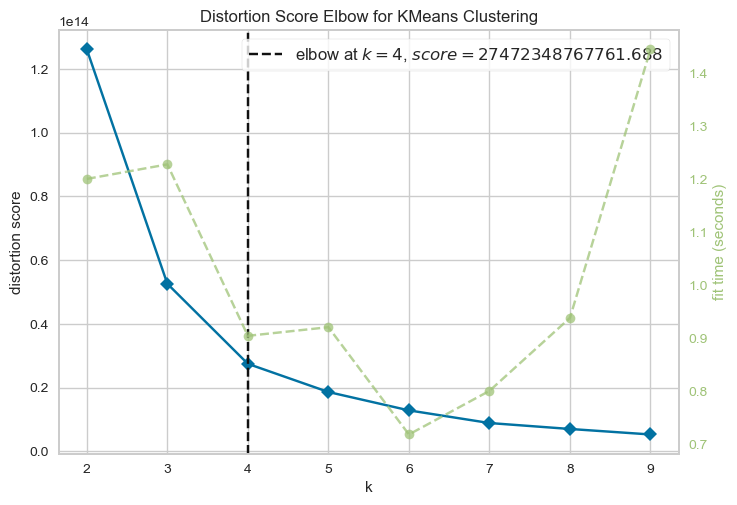

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [77]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

model = KMeans(random_state=1004)
visualizer = KElbowVisualizer(model, k=(2, 10))  # 2에서 10까지 군집 수를 테스트
visualizer.fit(df['price'].values.reshape(-1, 1))  # 데이터에 맞춰 학습
visualizer.show()  # 그래프 출력

In [78]:
# K-means 클러스터링
kmeans = KMeans(n_clusters=4, random_state=1004)
df['price_cluster'] = kmeans.fit_predict(df[['price']])

c:\Users\gmldu\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


c:\Users\gmldu\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\gmldu\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\gmldu\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\gmldu\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

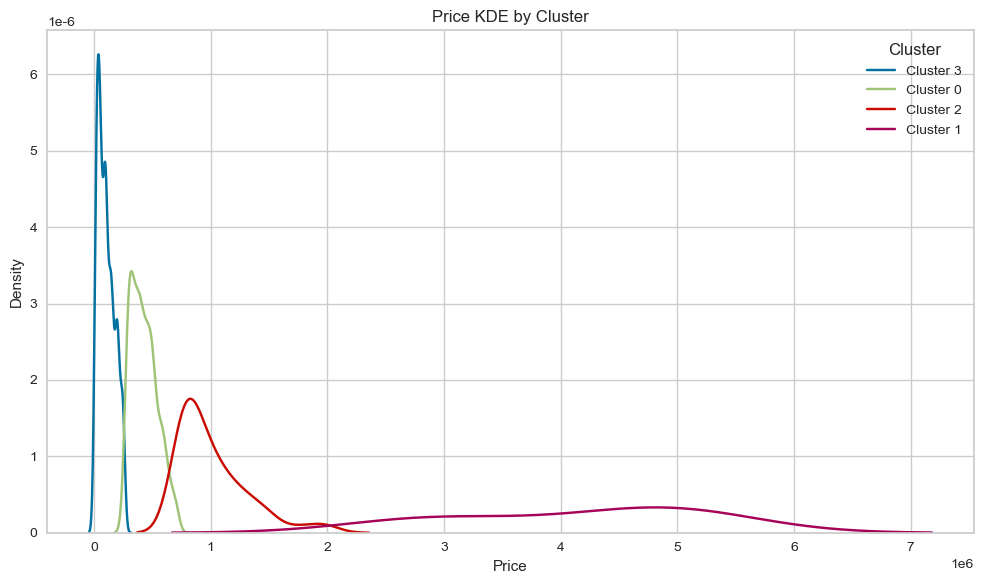

In [109]:
plt.figure(figsize=(10, 6))

for cluster in df['price_cluster'].unique():
    sns.kdeplot(df[df['price_cluster'] == cluster]['price'], label=f'Cluster {cluster}')

plt.title('Price KDE by Cluster')
plt.xlabel('Price')
plt.ylabel('Density')

plt.legend(title='Cluster')

plt.tight_layout()
plt.show()

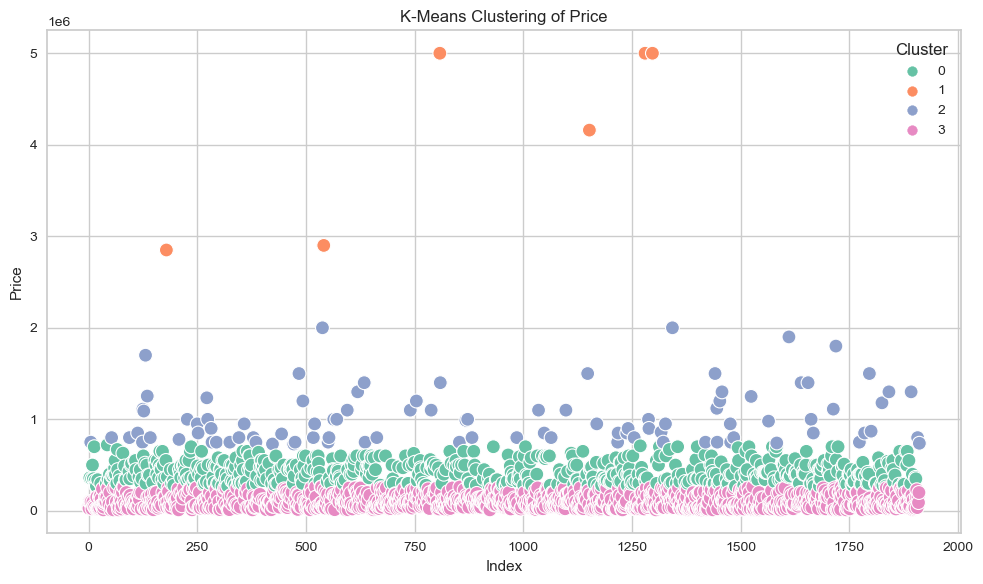

In [108]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df.index, y='price', hue='price_cluster', palette='Set2', data=df, s=100)

plt.title('K-Means Clustering of Price')
plt.xlabel('Index')
plt.ylabel('Price')

plt.legend(title='Cluster', loc='best')

plt.tight_layout()
plt.show()

In [81]:
df.groupby('price_cluster')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
price_cluster,,,,,,,,
0,624.0,4.296244e+05,1.107714e+05,270000.0,340000.0,400000.0,500000.0,720000.0
1,6.0,4.151667e+06,1.041161e+06,2850000.0,3215000.0,4580000.0,5000000.0,5000000.0
2,97.0,1.014525e+06,2.977107e+05,730000.0,800000.0,950000.0,1120000.0,2000000.0
3,1185.0,1.065299e+05,7.058653e+04,10000.0,45000.0,100000.0,160000.0,265000.0


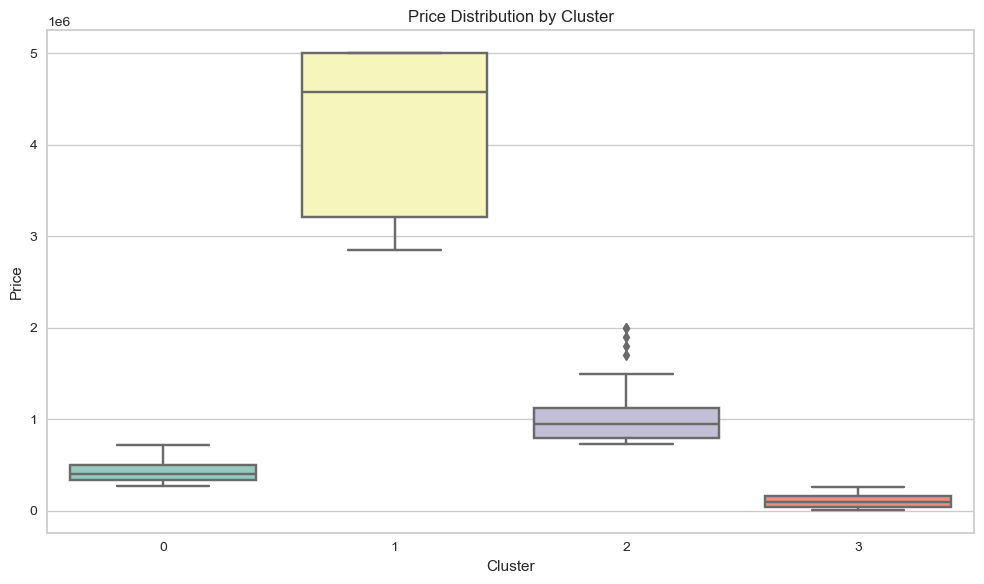

In [82]:
plt.figure(figsize=(10, 6))

sns.boxplot(x='price_cluster', y='price', data=df, palette='Set3')
plt.title('Price Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Price')

plt.tight_layout()
plt.show()


In [80]:
df.groupby('price_cluster')['stay_type'].value_counts()

price_cluster  stay_type
0              호텔           534
               리조트           54
               기타            29
               풀빌라            4
               모텔             2
               펜션             1
1              호텔             4
               리조트            1
               기타             1
2              호텔            83
               리조트            7
               기타             5
               모텔             1
               풀빌라            1
3              호텔           960
               리조트          127
               기타            84
               모텔             6
               펜션             4
               풀빌라            4
Name: count, dtype: int64

In [84]:
counts = df.groupby('price_cluster')['stay_type'].value_counts()
counts_df = counts.unstack(fill_value=0)
percentage_df = counts_df.div(counts_df.sum(axis=1), axis=0)
percentage_df

stay_type,기타,리조트,모텔,펜션,풀빌라,호텔
price_cluster,,,,,,
0,0.046474,0.086538,0.003205,0.001603,0.006410,0.855769
1,0.166667,0.166667,0.000000,0.000000,0.000000,0.666667
2,0.051546,0.072165,0.010309,0.000000,0.010309,0.855670
3,0.070886,0.107173,0.005063,0.003376,0.003376,0.810127


In [91]:
df.groupby('price_cluster')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
price_cluster,,,,,,,,
0,624.0,4.296244e+05,1.107714e+05,270000.0,340000.0,400000.0,500000.0,720000.0
1,6.0,4.151667e+06,1.041161e+06,2850000.0,3215000.0,4580000.0,5000000.0,5000000.0
2,97.0,1.014525e+06,2.977107e+05,730000.0,800000.0,950000.0,1120000.0,2000000.0
3,1185.0,1.065299e+05,7.058653e+04,10000.0,45000.0,100000.0,160000.0,265000.0


In [85]:
counts_df

stay_type,기타,리조트,모텔,펜션,풀빌라,호텔
price_cluster,,,,,,
0,29,54,2,1,4,534
1,1,1,0,0,0,4
2,5,7,1,0,1,83
3,84,127,6,4,4,960


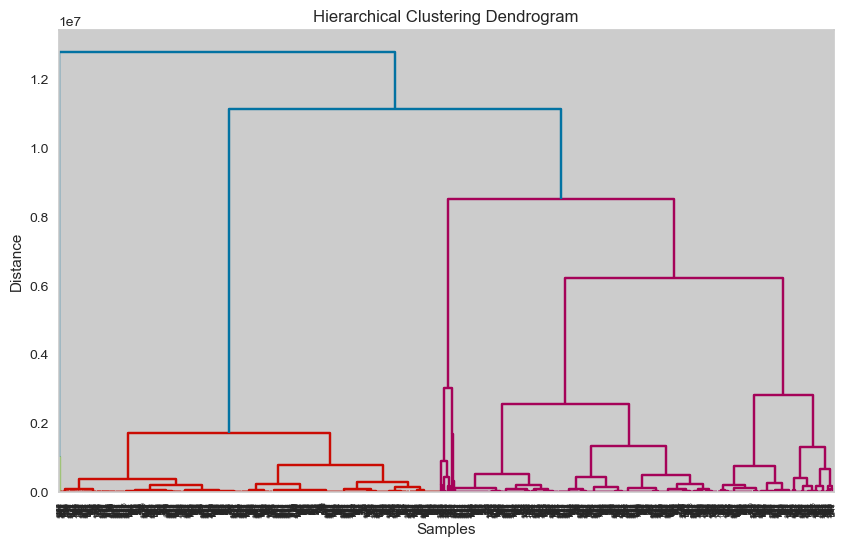

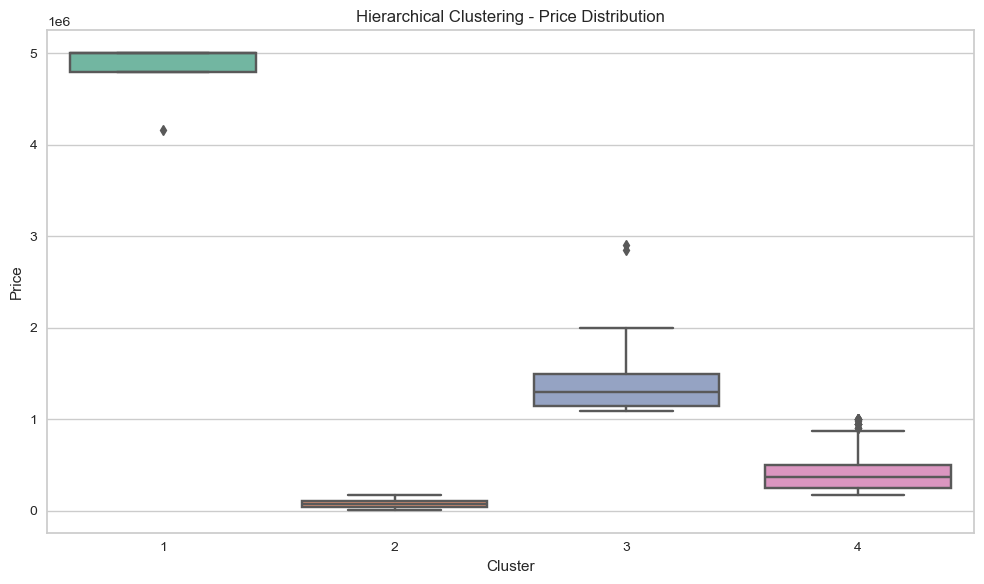

In [100]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

Z = linkage(df[['price']], method='ward')


plt.figure(figsize=(10, 6))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

df['price_hierarchical'] = fcluster(Z, 4, criterion='maxclust')

plt.figure(figsize=(10, 6))
sns.boxplot(x='price_hierarchical', y='price', data=df, palette='Set2')
plt.title('Hierarchical Clustering - Price Distribution')
plt.xlabel('Cluster')
plt.ylabel('Price')
plt.tight_layout()
plt.show()

In [101]:
df.groupby('price_hierarchical')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
price_hierarchical,,,,,,,,
1,4.0,4.790000e+06,420000.000000,4160000.0,4790000.0,5000000.0,5000000.0,5000000.0
2,937.0,7.763423e+04,46321.432368,10000.0,38000.0,70000.0,110000.0,170000.0
3,35.0,1.440022e+06,441502.696311,1090000.0,1150000.0,1300000.0,1500000.0,2900000.0
4,936.0,4.010026e+05,178149.143186,174000.0,250000.0,365000.0,500000.0,1000000.0


In [107]:
df.groupby('price_cluster')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
price_cluster,,,,,,,,
0,624.0,4.296244e+05,1.107714e+05,270000.0,340000.0,400000.0,500000.0,720000.0
1,6.0,4.151667e+06,1.041161e+06,2850000.0,3215000.0,4580000.0,5000000.0,5000000.0
2,97.0,1.014525e+06,2.977107e+05,730000.0,800000.0,950000.0,1120000.0,2000000.0
3,1185.0,1.065299e+05,7.058653e+04,10000.0,45000.0,100000.0,160000.0,265000.0


In [119]:
df = pd.read_pickle('processed_data.pkl')

In [120]:
df['platform'].value_counts()

platform
중고나라    3859
당근마켓    2406
번개장터    1566
Name: count, dtype: int64

In [121]:
df

,platform,original_link,post_time,title,view_count,like_count,price,images,description,category,...,capacity,parking,options,check_in_out_time,shipping_fee,transaction_location,transaction_method,city,city_goo,city_dong
0,당근마켓,https://www.daangn.com/articles/846645149,2024-10-11 19:12:01.203000,호텔숙바퀀,25,0,10000,https://img.kr.gcp-karroter.net/origin/article...,6시입실 내일12시퇴실\n가려했는데같이가는사람이 시간이 안맞아서요~,티켓/교환권,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,계양구,작전서운동
1,당근마켓,https://www.daangn.com/articles/846644988,2024-10-11 19:12:01.203000,용산역 호텔숙박권,15,1,280000,https://img.kr.gcp-karroter.net/origin/article...,용산역 4성급 호텔 이비스 스타일 앰버서더 숙박권입니다! \n날짜 내일 10월 *...,티켓/교환권,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,서울특별시,강남구,역삼동
2,당근마켓,https://www.daangn.com/articles/846639021,2024-10-11 19:01:01.203000,호텔 아쿠아펠리스 숙박권,79,2,100000,https://img.kr.gcp-karroter.net/origin/article...,사정이생겨 못가게되서\n선착순한명 싸게드릴께요,티켓/교환권,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,수영구,망미동
3,당근마켓,https://www.daangn.com/articles/846637216,2024-10-11 18:58:01.203000,워커힐호텔 피자힐,39,2,90000,https://img.kr.gcp-karroter.net/origin/article...,피자힐 10만원권 9만원에 판매합니다~!,티켓/교환권,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,서울특별시,관악구,신림동
4,당근마켓,https://www.daangn.com/articles/846637088,2024-10-11 18:58:01.203000,대만 시먼딩 puri ximen 호텔 양도(3/1-3/3),6,1,150000,https://img.kr.gcp-karroter.net/origin/article...,대만 시먼딩에 위치한 puri ximen 호텔 양도합니다\n내년 연휴인 3/1-3/...,티켓/교환권,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,익산시,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7826,중고나라,https://web.joongna.com/product/177764839,2024-07-24 10:39:59,롯데호텔 시그니엘서울 애프터눈티 세트 16>13,20,0,130000,https://img2.joongna.com/cafe-article-data/liv...,16>13,기타 티켓/쿠폰/이용권,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None
7827,중고나라,https://web.joongna.com/product/177767396,2024-07-24 10:55:25,영등포 리더스 호텔(모텔)7/27-28디락스 트윈룸 숙박권 양도합니다,28,0,70000,/cafe-article-data/live/2024/07/24/1067914533/...,일정에 갑자기 차질이 생겨서 숙박권 판매 하려고 합니다 혹시 생각 있으신 분은 연락...,여행숙박/이용권,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None
7828,중고나라,https://web.joongna.com/product/177766185,2024-07-24 10:47:40,롯데호텔통합숙박권,93,2,300000,https://img2.joongna.com/cafe-article-data/liv...,롯데호텔통합숙박권입니다 사용처 및 구성은 사진에 나와있습니다 24년 12월 말까지 ...,여행숙박/이용권,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None
7829,중고나라,https://web.joongna.com/product/177758738,2024-07-24 09:59:22,씨마크 호텔이용권 (11만원),22,1,85000,https://img2.joongna.com/cafe-article-data/liv...,호텔이용권입니다 11만원 이용권 24.8.31 까지,여행숙박/이용권,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None
